In [2]:
import os
import scipy.io as sio 
import path
import pandas as pd
import numpy as np
import collections
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import tensorflow as tf
tf.__version__

'1.12.0'

数据说明：
1. 对于PSG数据
   - stage 睡眠所处阶段
   - 3 -> 醒来， 2 -> 浅睡， 1 -> 深睡

In [5]:
data_root=r"E:\datasources\MS10Data"
p = r"E:\datasources\MS10Data\1\psg\psg.mat"
rdp=r"E:\datasources\MS10Data\1\raw\rawMat.mat"
save_data=r"E:\datasources\MS10DataTF"

In [6]:
psg_data_paths=[os.path.join(data_root,f"{i}\\psg\\psg.mat") for i in range(1,33)]
raw_data_paths=[os.path.join(data_root,f"{i}\\raw\\rawMat.mat") for i in range(1,33)]
psg_raw_data_paths=list(zip(psg_data_paths,raw_data_paths))

In [7]:
def parse_mat_psg(fp):
    psg1=sio.loadmat(fp)
    ti=np.apply_along_axis(lambda row:row[0],0,psg1["psgStage"]['Time']).flatten()
    st=np.apply_along_axis(lambda row:row[0],0,psg1["psgStage"]['stage']).flatten()
    st=np.apply_along_axis(lambda x:int(x),1,st.reshape(-1,1))
    print(st.shape)
    return pd.DataFrame(np.vstack([ti,st]).transpose(),columns=['time','stage'])

def parse_mat_signal(fp):
    rs=sio.loadmat(fp)
    r1=rs['rawData']['dataSignalOld'][0,0]
    r2=rs['rawData']['dataSignal'][0,0]
    r3=rs['rawData']['dataSwitch'][0,0]
    r4=rs['rawData']['Time'][0,0]
    return pd.DataFrame(np.hstack([r1,r2,r3,r4]),columns=['data_signal_old','data_signal','data_switch','time'])

def parse_mat_time(matlab_datenum):
    return datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    

In [8]:
# 数据解析生成tf-record
# 定义特征对象
def _int64_feature(value):
    """生成一个对应类型的特征对象"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    """生成一个对应类型的特征对象"""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """生成一个对应类型的特征对象"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _make_named_features(named_features):
    """生成一个命名的特征，给特征对象赋予一个schema"""
    return tf.train.Features(feature=named_features)

# 定义序列record，多了一层包裹的抽象
def _feature_list(feature_list):
    """生成一个特征对象的序列"""
    return tf.train.FeatureList(feature=feature_list)

def _make_named_featurelists(named_featurelists):
    """生成一个命名的特征，给特征对象的序列赋予一个schema"""
    return tf.train.FeatureLists(feature_list=named_featurelists)

In [13]:
f1=tf.train.Feature(int64_list=tf.train.Int64List(value=[13,12]))
f2=tf.train.Feature(int64_list=tf.train.Int64List(value=[12]))
f3=tf.train.Feature(bytes_list=tf.train.BytesList(value=[b"abcde",b"abcde"]))

example = tf.train.Example(features=_make_named_features({"f1":f1,"f2":f2,"f3":f3}))

#f1=tf.train.Feature(int64_list=tf.train.Int64List(value=[]))
f2=tf.train.Feature(int64_list=tf.train.Int64List(value=[22]))
f3=tf.train.Feature(bytes_list=tf.train.BytesList(value=[b"cde",b"abcde"]))

example2 = tf.train.Example(features=_make_named_features({"f2":f2,"f3":f3}))

_features = {
    'f1': tf.FixedLenFeature([2], dtype=tf.int64,default_value=[3,5]),
    'f2': tf.FixedLenFeature([1], dtype=tf.int64),
    'f3': tf.FixedLenFeature([2], dtype=tf.string),
}



In [16]:
f1=tf.train.Feature(int64_list=tf.train.Int64List(value=[12]))
f2=tf.train.Feature(int64_list=tf.train.Int64List(value=[34]))
f3=tf.train.Feature(bytes_list=tf.train.BytesList(value=[b"abcde",b"abcde"]))

example = tf.train.Example(features=_make_named_features({"f1":f1,"f2":f2,"f3":f3}))

f1=tf.train.Feature(int64_list=tf.train.Int64List(value=[45,12]))
f2=tf.train.Feature(int64_list=tf.train.Int64List(value=[34]))
f3=tf.train.Feature(bytes_list=tf.train.BytesList(value=[b"cde",b"abcde"]))

example2 = tf.train.Example(features=_make_named_features({"f1":f1,"f2":f2,"f3":f3}))

_features = {
    'f1': tf.VarLenFeature(dtype=tf.int64),
    'f2': tf.FixedLenFeature([1], dtype=tf.int64),
    'f3': tf.FixedLenFeature([2], dtype=tf.string),
}

In [17]:
filename='movie_ratings2.tfrecord'
if tf.gfile.Exists(filename):
    print(tf.gfile.Exists(filename))
    tf.gfile.Remove(filename)
    print(tf.gfile.Exists(filename))

with tf.python_io.TFRecordWriter(filename) as writer:
    writer.write(example.SerializeToString())
    writer.write(example2.SerializeToString())
    writer.close()

In [18]:

dataset = tf.data.TFRecordDataset(filename)

iterator=dataset.make_one_shot_iterator()
it=iterator.get_next()
ps=tf.parse_single_example(it,features=_features)

In [19]:
with tf.Session() as sess:
    for _ in range(2):
        print(sess.run(ps))

{'f1': SparseTensorValue(indices=array([[0]], dtype=int64), values=array([12], dtype=int64), dense_shape=array([1], dtype=int64)), 'f2': array([34], dtype=int64), 'f3': array([b'abcde', b'abcde'], dtype=object)}
{'f1': SparseTensorValue(indices=array([[0],
       [1]], dtype=int64), values=array([45, 12], dtype=int64), dense_shape=array([2], dtype=int64)), 'f2': array([34], dtype=int64), 'f3': array([b'cde', b'abcde'], dtype=object)}


In [32]:
_features = {
    'f1': tf.FixedLenFeature([], dtype=tf.int64),
    'f2': tf.FixedLenFeature([], dtype=tf.int64),
    'f3': tf.VarLenFeature(dtype=tf.string),
}

dataset = tf.data.TFRecordDataset(filename)

iterator=dataset.make_one_shot_iterator()
it=iterator.get_next()
ps=tf.parse_single_example(it,features=_features)
sess.run(ps)

{'f3': SparseTensorValue(indices=array([[0],
        [1]], dtype=int64), values=array([b'abcde', b'abcde'], dtype=object), dense_shape=array([2], dtype=int64)),
 'f1': 12,
 'f2': 34}

In [33]:
a=sess.run(ps['f3'])
a.values

array([b'cde', b'abcde'], dtype=object)

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000., 18000.]), <a list of 11 Text yticklabel objects>)

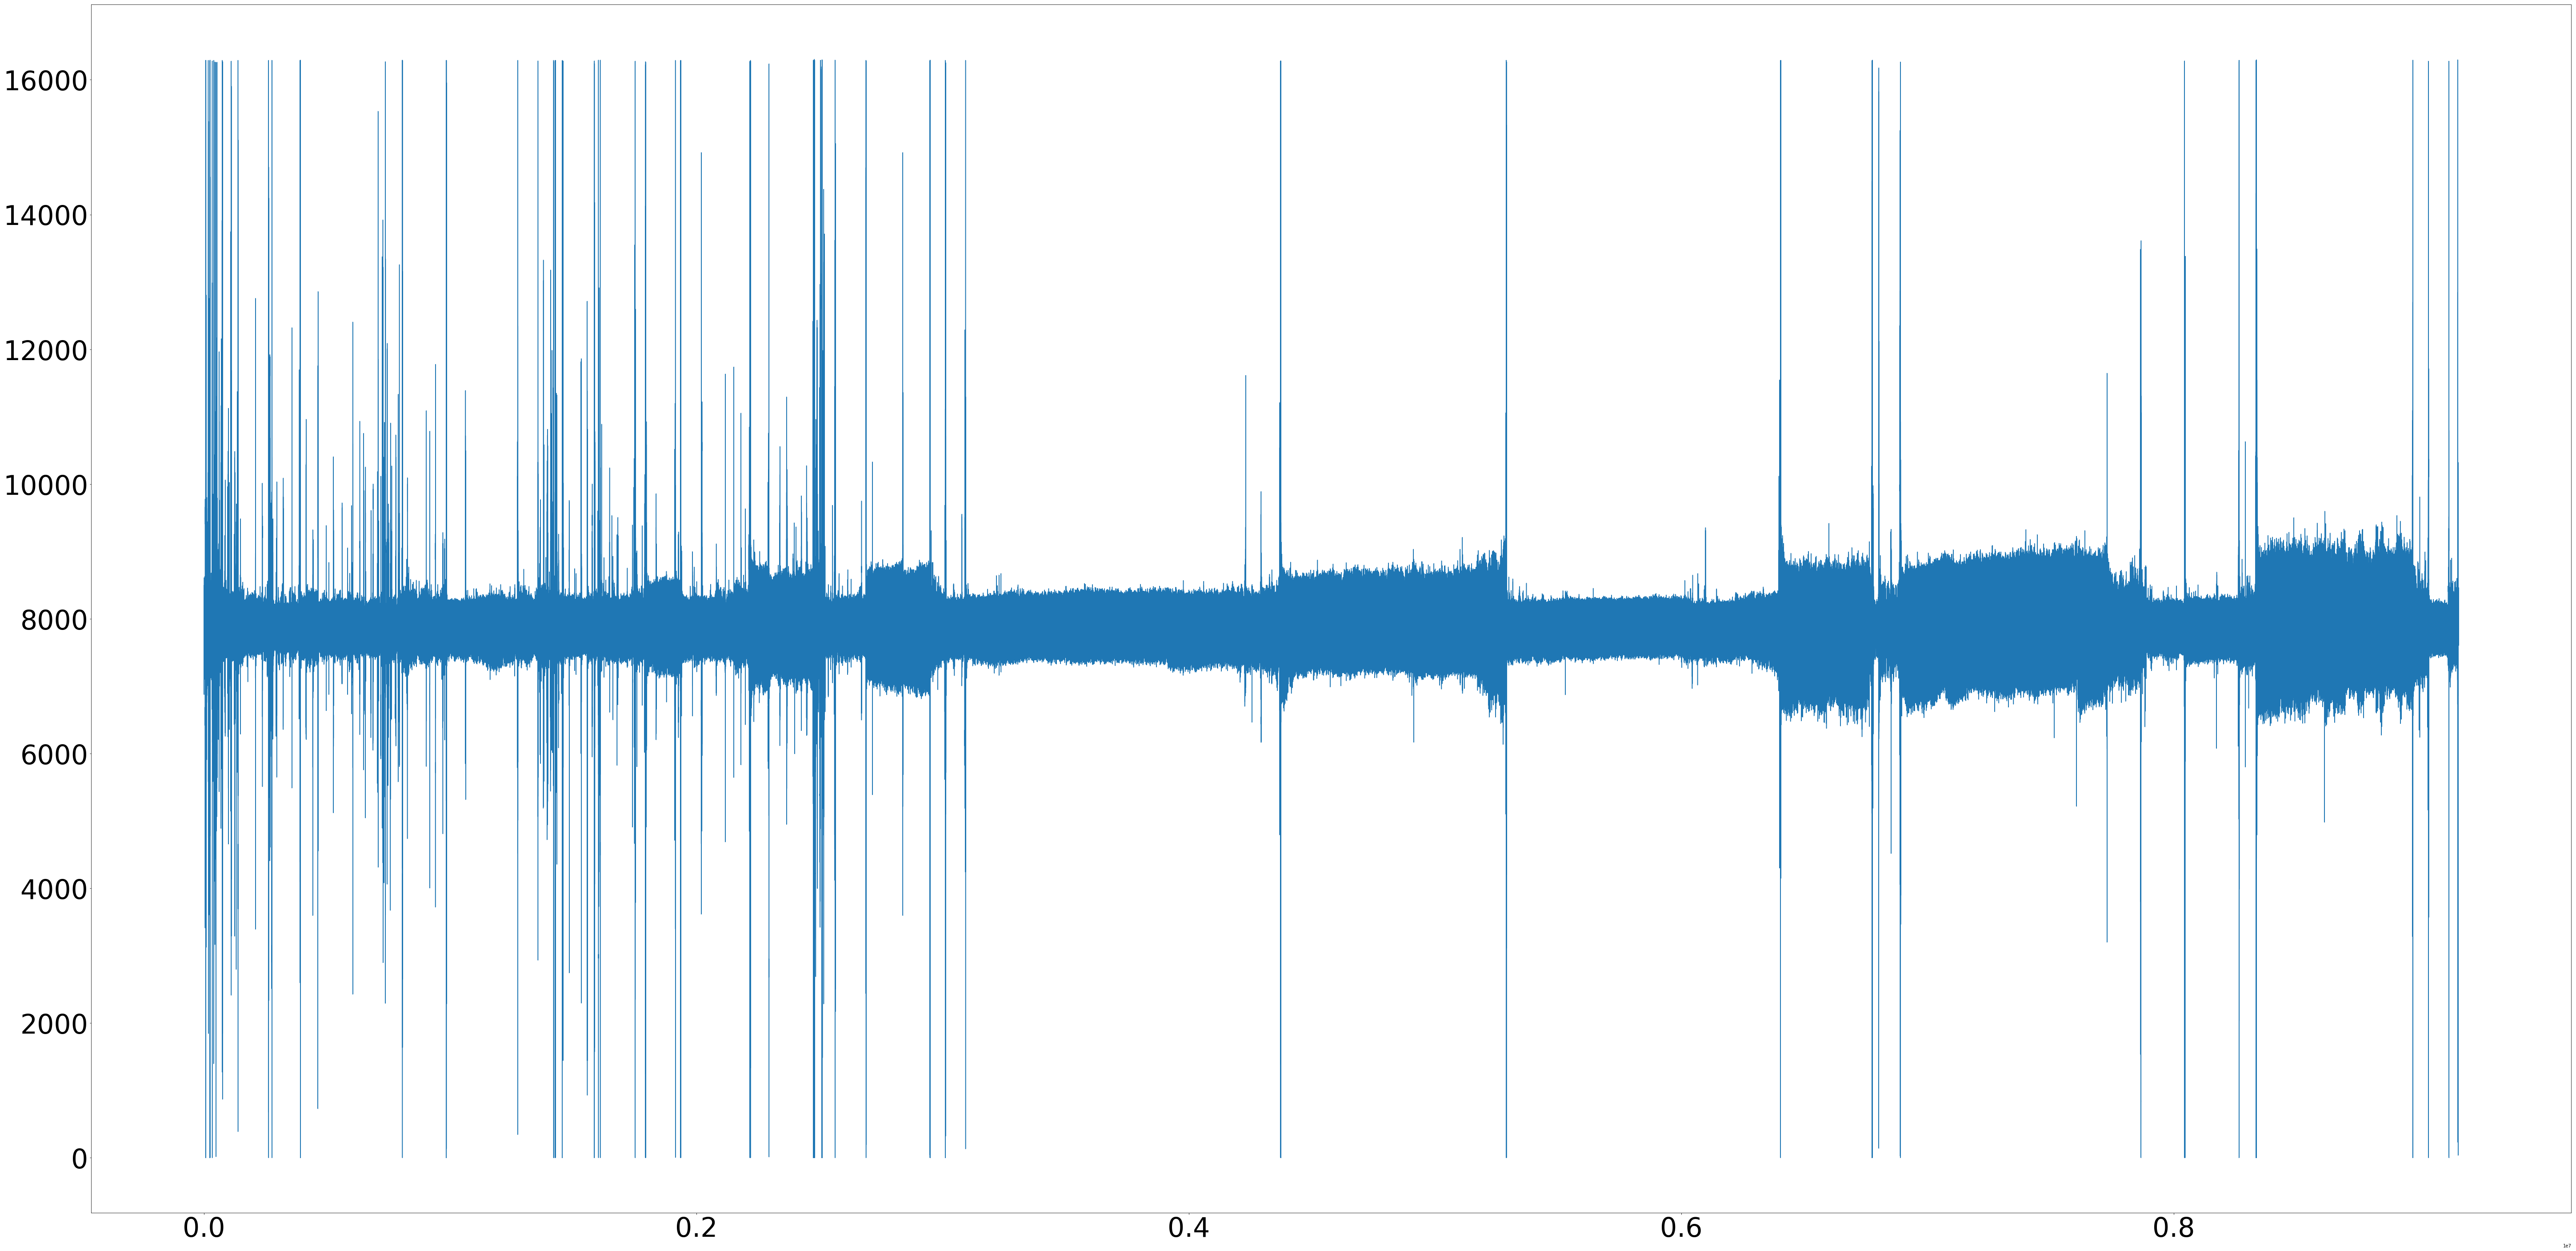

In [25]:
plt.figure(figsize=(100,50))
plt.plot(signal['data_signal'],)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)


In [18]:
signal=parse_mat_signal(rdp)
psg=parse_mat_psg(p)

psg_time=psg['time'].values
psg_stage=psg['stage'].values
psg_int=list(zip(psg_time[:-1],psg_time[1:],psg_stage[1:]))

def make_signal_psg_list(psg,signal):
    signal_list=[]
    psg_list=[]
    psg_time=psg['time'].values
    psg_stage=psg['stage'].values
    psg_int=list(zip(psg_time[:-1],psg_time[1:],psg_stage[1:]))
    for it in psg_int:
        signal_list.append(signal.query(f"(time>{it[0]})and(time<{it[1]})")['data_signal'].values)
        psg_list.append(it[2])
    return signal_list,psg_list

(1116,)


In [63]:
signal_list,psg_list=make_signal_psg_list(psg,signal)

In [64]:
c=0

named_featurelists=collections.defaultdict(list)

for sig,label in zip(signal_list,psg_list):
    c+=1
    if c<10:
        named_featurelists['signal_seq'].append(_bytes_feature(sig.tostring()))
        named_featurelists['psg_seq'].append(_int64_feature(int(label)))
        print(sig,label)
    res=_make_named_featurelists({k:_feature_list(v) for k,v in named_featurelists.items()})
    

[7952. 8192. 8204. ... 7584. 7796. 7876.] 3.0
[7692. 7508. 7560. ... 7776. 7552. 7528.] 3.0
[7728. 7904. 7836. ... 7792. 7804. 8020.] 3.0
[8164. 8044. 7812. ... 9532. 9496. 9668.] 3.0
[9856. 9772. 9576. ... 7984. 8180. 8352.] 3.0
[8204. 8000. 7968. ... 7836. 7744. 7940.] 3.0
[8116. 8080. 7868. ... 9172. 9336. 9252.] 3.0
[9032. 8940. 9112. ... 7900. 7972. 7804.] 3.0
[7620. 7636. 7856. ... 7424. 7500. 7752.] 3.0


In [65]:
example = tf.train.SequenceExample(feature_lists=res)
with tf.python_io.TFRecordWriter('movie_ratings.tfrecord') as writer:
    writer.write(example.SerializeToString())
    writer.write(example.SerializeToString())


In [34]:
sequence_features = {
    'signal_seq': tf.FixedLenSequenceFeature([], dtype=tf.string),
    'psg_seq': tf.FixedLenSequenceFeature([], dtype=tf.int64),
}

dataset = tf.data.TFRecordDataset("movie_ratings.tfrecord")
#dataset = dataset.batch(1)
dataset=dataset.shuffle(200)
iterator=dataset.make_one_shot_iterator()
it=iterator.get_next()
ps=tf.parse_single_sequence_example(it,sequence_features=sequence_features)

In [78]:
tf.

({},
 {'psg_seq': <tf.Tensor 'ParseSingleSequenceExample_16/ParseSingleSequenceExample:0' shape=(?,) dtype=int64>,
  'signal_seq': <tf.Tensor 'ParseSingleSequenceExample_16/ParseSingleSequenceExample:1' shape=(?,) dtype=string>})

In [80]:
sess.run(tf.decode_raw(ps[1]['signal_seq'],tf.float64)).shape

(9, 7680)

In [ ]:
tf.decode_raw(features['image_raw'], tf.uint8)
tf.dec

In [87]:
# 生成tf.record文件
# 本身项目标数据结构
ar3=df3['data_signal'].values

In [84]:
def parse_tf_example(example_proto):

    feature_spec = {}

    for feature_name in NUMERIC_FEATURE_NAMES:
        feature_spec[feature_name] = tf.FixedLenFeature(shape=(1), dtype=tf.float32)
    
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        feature_spec[feature_name] = tf.FixedLenFeature(shape=(1), dtype=tf.string)
    
    feature_spec[TARGET_NAME] = tf.FixedLenFeature(shape=(1), dtype=tf.float32)

    parsed_features = tf.parse_example(serialized=example_proto, features=feature_spec)
    
    target = parsed_features.pop(TARGET_NAME)
    
    return parsed_features, target


def process_features(features):
    
    # example of clipping
    features['x'] = tf.clip_by_value(features['x'], clip_value_min=-3, clip_value_max=3)
    features['y'] = tf.clip_by_value(features['y'], clip_value_min=-3, clip_value_max=3)
    
    # example of polynomial expansion
    features["x_2"] = tf.square(features['x'])
    features["y_2"] = tf.square(features['y'])
    
    # example of nonlinearity
    features["xy"] = features['x'] * features['y']
    
    # example of custom logic
    features['dist_xy'] =  tf.sqrt(tf.squared_difference(features['x'],features['y']))
    features["sin_x"] = tf.sin(features['x'])
    features["cos_y"] = tf.sin(features['y'])    
    return features

def tfrecods_input_fn(files_name_pattern, mode=tf.estimator.ModeKeys.EVAL, 
                 num_epochs=None, 
                 batch_size=200):
    
    shuffle = True if mode == tf.estimator.ModeKeys.TRAIN else False
    
    print("")
    print("* data input_fn:")
    print("================")
    print("Input file(s): {}".format(files_name_pattern))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Shuffle: {}".format(shuffle))
    print("================")
    print("")

    file_names = tf.matching_files(files_name_pattern)
    dataset = data.TFRecordDataset(filenames=file_names)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example))
    
    if PROCESS_FEATURES:
        dataset = dataset.map(lambda features, target: (process_features(features), target))
        
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator()
    
    features, target = iterator.get_next()
    return features, target

In [78]:
movie_name_list = tf.train.BytesList(value=[b'The Shawshank Redemption', b'Fight Club'])
movie_rating_list = tf.train.FloatList(value=[9.0, 9.7, 5.5])

movie_names = tf.train.Feature(bytes_list=movie_name_list)
movie_ratings = tf.train.Feature(float_list=movie_rating_list)

In [79]:
movie_dict = { 'Movie Names': movie_names, 'Movie Ratings': movie_ratings}
movies = tf.train.Features(feature=movie_dict)
example = tf.train.Example(features=movies)

In [81]:
tf.parse_example(example)

TypeError: parse_example() missing 1 required positional argument: 'features'

In [80]:
example

features {
  feature {
    key: "Movie Names"
    value {
      bytes_list {
        value: "The Shawshank Redemption"
        value: "Fight Club"
      }
    }
  }
  feature {
    key: "Movie Ratings"
    value {
      float_list {
        value: 9.0
        value: 9.699999809265137
        value: 5.5
      }
    }
  }
}

In [77]:
with tf.python_io.TFRecordWriter('movie_ratings.tfrecord') as writer:
    writer.write(example.SerializeToString())

In [31]:
psg_int

[(737201.8848958333, 737201.8852430537, 3.0),
 (737201.8852430537, 737201.885590274, 3.0),
 (737201.885590274, 737201.8859374943, 3.0),
 (737201.8859374943, 737201.8862847147, 3.0),
 (737201.8862847147, 737201.886631935, 3.0),
 (737201.886631935, 737201.8869791554, 3.0),
 (737201.8869791554, 737201.8873263757, 3.0),
 (737201.8873263757, 737201.887673596, 3.0),
 (737201.887673596, 737201.8880208164, 3.0),
 (737201.8880208164, 737201.8883680367, 3.0),
 (737201.8883680367, 737201.888715257, 3.0),
 (737201.888715257, 737201.8890624774, 3.0),
 (737201.8890624774, 737201.8894096977, 3.0),
 (737201.8894096977, 737201.8897569181, 3.0),
 (737201.8897569181, 737201.8901041384, 3.0),
 (737201.8901041384, 737201.8904513587, 3.0),
 (737201.8904513587, 737201.8907985791, 3.0),
 (737201.8907985791, 737201.8911457994, 3.0),
 (737201.8911457994, 737201.8914930198, 3.0),
 (737201.8914930198, 737201.8918402401, 3.0),
 (737201.8918402401, 737201.8921874604, 3.0),
 (737201.8921874604, 737201.8925346808, 3.

In [26]:
df2.query("(time>737201.8932291215)and(time<737201.8935763418)")

,dataSignalOld,dataSignal,dataSwitch,time
262401,10592.0,10592.0,1.0,737201.893229
262402,10552.0,10552.0,1.0,737201.893229
262403,10348.0,10348.0,1.0,737201.893229
262404,10252.0,10252.0,1.0,737201.893229
262405,10404.0,10404.0,1.0,737201.893229
262406,10592.0,10592.0,1.0,737201.893229
262407,10540.0,10540.0,1.0,737201.893229
262408,10316.0,10316.0,1.0,737201.893229
262409,10160.0,10160.0,1.0,737201.893230
262410,10292.0,10292.0,1.0,737201.893230


In [28]:
30*256

7680

In [9]:
dt=datetime.fromordinal(int(matlab_datenum) - 366) + timedelta(days=matlab_datenum%1)

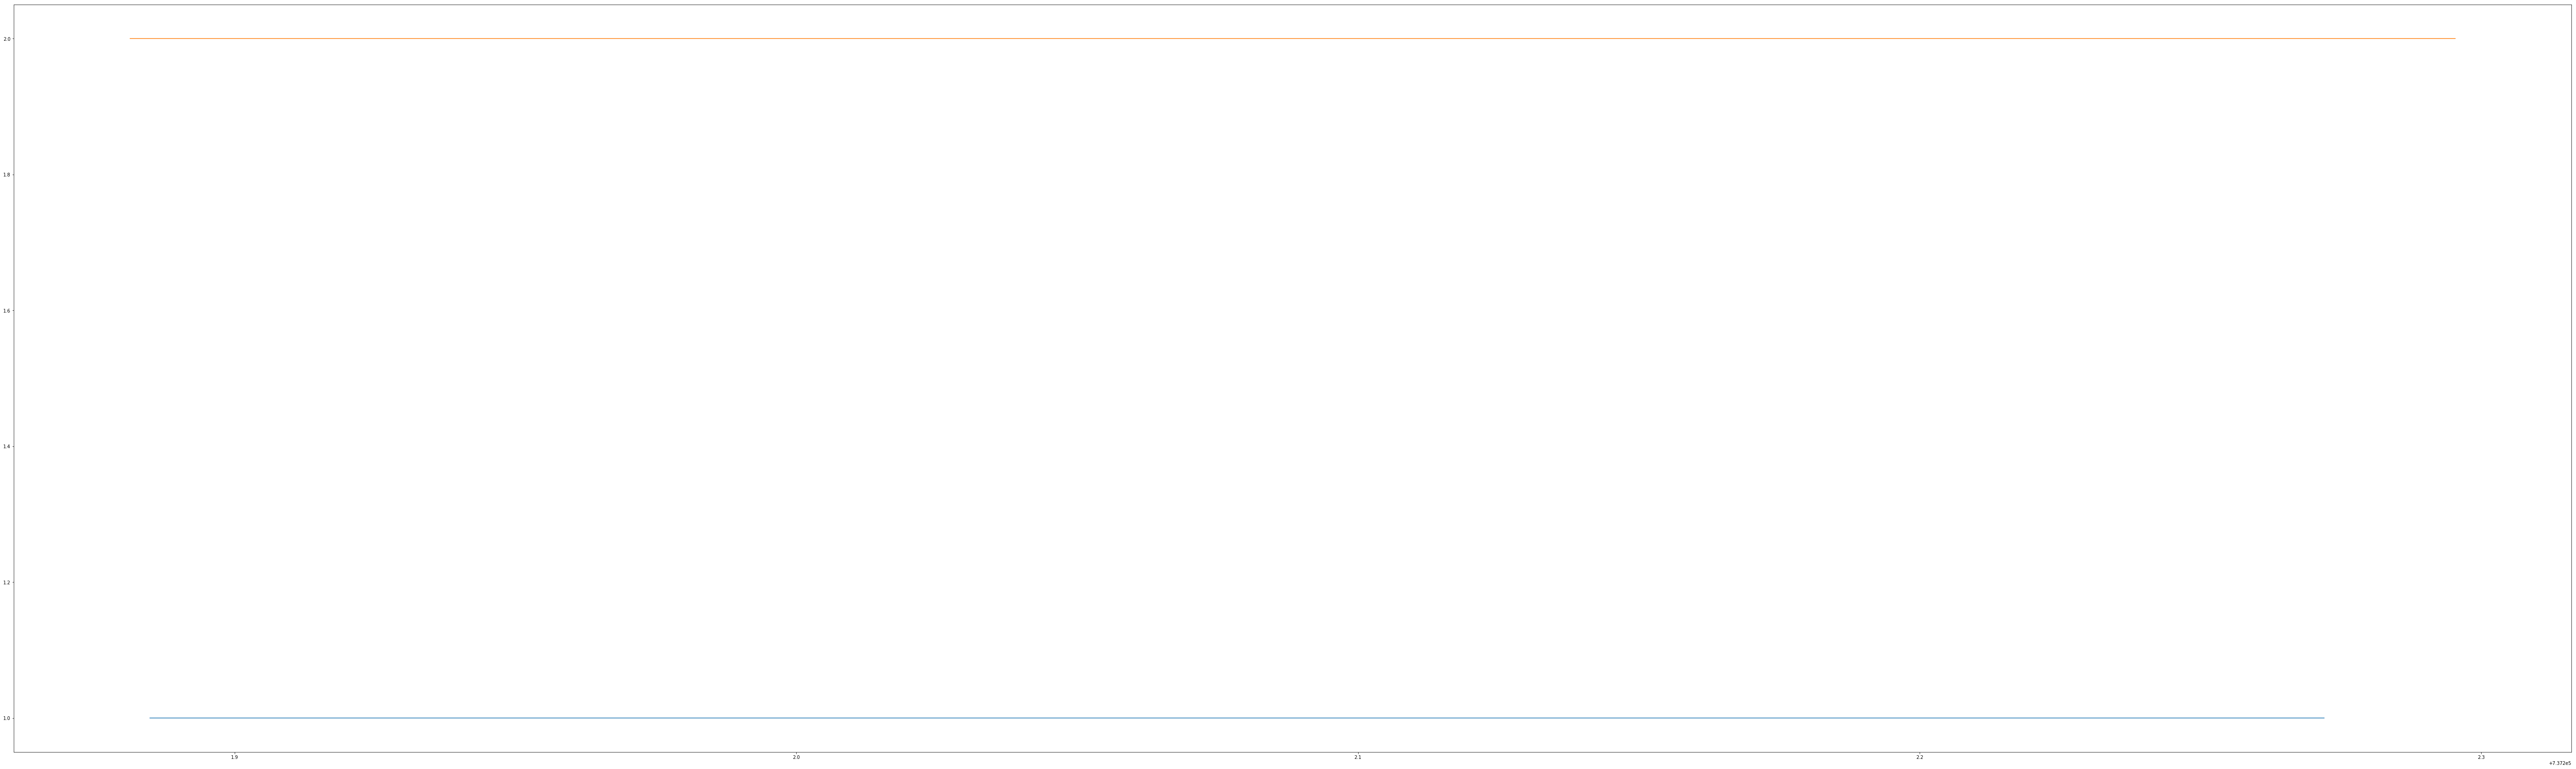

In [10]:
plt.figure(figsize=(100,30))
plt.plot(df['time'],[1]*len(df))
plt.plot(df2['time'],[2]*len(df2))
plt.show()

In [ ]:
df.merge(df2,on='time')

In [ ]:
dt.time()

In [ ]:
df2[df2["time"]==737201.9848952909]

In [ ]:
for i in df2.query("time>737201.9 and time<737201.99")['time']:print(i)

In [18]:
td=parse_mat_time(df['time'][0])-parse_mat_time(df['time'][1])


In [16]:
parse_mat_time(df['time'][0])

datetime.datetime(2018, 5, 21, 21, 14, 14, 999999)

In [17]:
parse_mat_time(df['time'][1])

datetime.datetime(2018, 5, 21, 21, 14, 44, 999837)

In [19]:
td.seconds

86370

In [21]:
td.total_seconds()

-29.999838

In [25]:
t1=parse_mat_time(df['time'][0])
t2=parse_mat_time(df['time'][1])


In [26]:
t1.second,t2.second

(14, 44)